In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tseries.offsets import YearEnd
import pymannkendall as mk

In [5]:
ega = pd.read_csv("all_EGA_samples.txt", parse_dates=["date_study"], sep=';')
dbgap = pd.read_csv("dbgap_may2024.csv", parse_dates=["year"])

ega['year'] = ega['date_study'].dt.year
dbgap['year'] = dbgap['year'].dt.year

# dbgap percentages
grouped = dbgap.groupby('year').agg({'male': 'sum', 'female': 'sum', 'unknown': 'sum'})
grouped['total'] = grouped['male'] + grouped['female'] + grouped['unknown']
grouped['percent_male'] = (grouped['male'] / grouped['total']) * 100
grouped['percent_female'] = (grouped['female'] / grouped['total']) * 100
grouped['percent_unknown'] = (grouped['unknown'] / grouped['total']) * 100
dbgap_percentages = grouped[['percent_male', 'percent_female', 'percent_unknown']]

# ega percentages
ega['percent_male'] = (ega['male'] / ega['total']) * 100
ega['percent_female'] = (ega['female'] / ega['total']) * 100
ega['percent_unknown'] = (ega['unknown'] / ega['total']) * 100
ega_percentages = ega.groupby('year').agg({
    'percent_male': 'mean',
    'percent_female': 'mean',
    'percent_unknown': 'mean'
}).reset_index()
ega_percentages = ega_percentages[ega_percentages['year'] > 2008]

# align the two yearly percentages of unknowns
merged_data = pd.merge(ega_percentages[['year', 'percent_unknown']], 
                       dbgap_percentages[['percent_unknown']], 
                       on='year', 
                       how='outer', 
                       suffixes=('_ega', '_dbgap'))

merged_data.sort_values('year', inplace=True)

merged_data.rename(columns={'percent_unknown_ega': 'ts1', 'percent_unknown_dbgap': 'ts2'}, inplace=True)

all_years = range(merged_data['year'].min(), merged_data['year'].max() + 1)
merged_data.set_index('year', inplace=True)
merged_data = merged_data.reindex(all_years)

ts1 = merged_data['ts1'].values
ts2 = merged_data['ts2'].values
time = merged_data.index.values

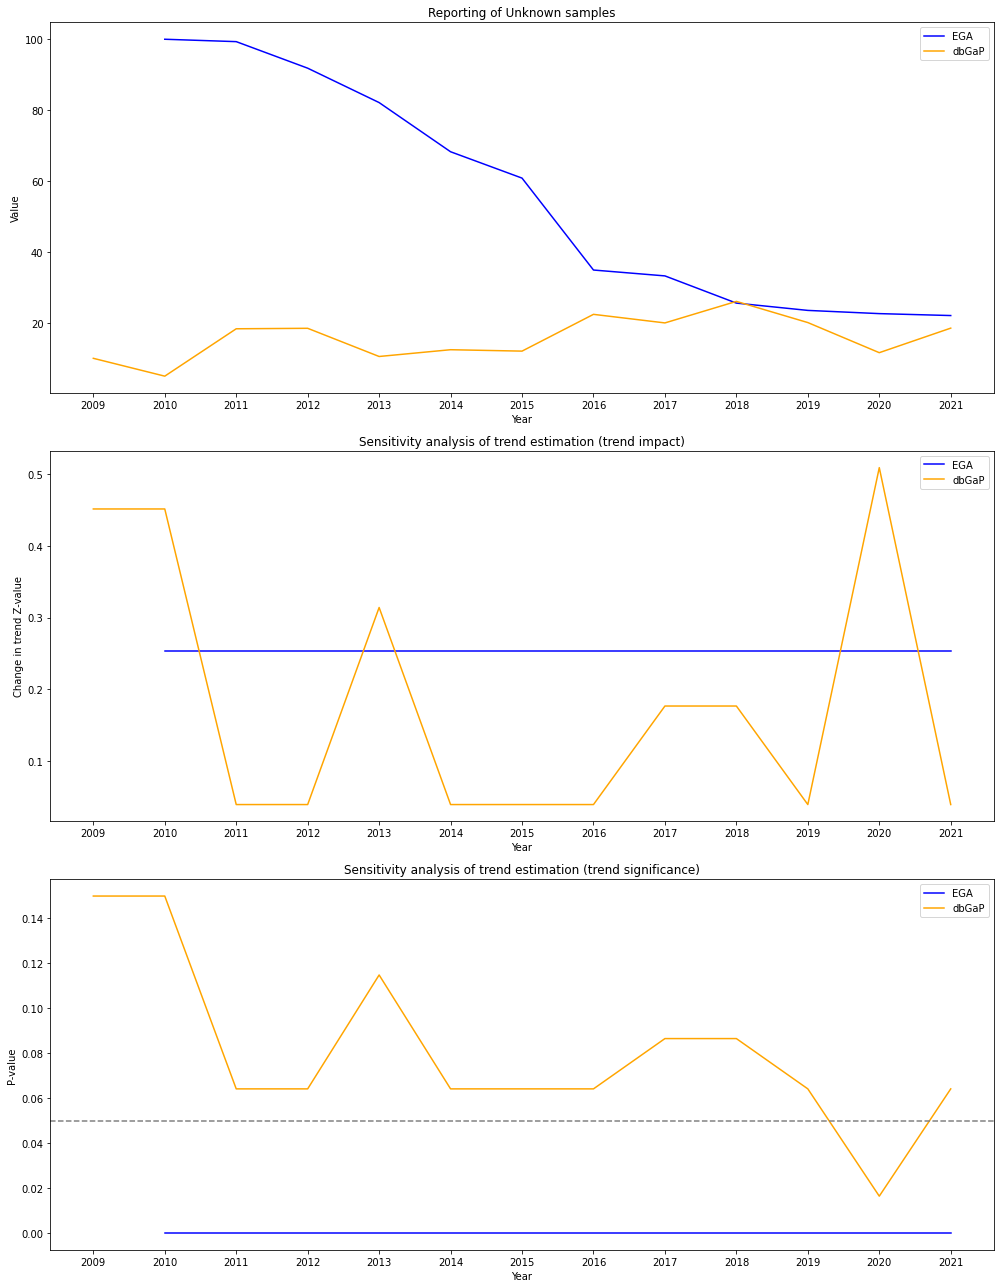

EGA Results:
Trend: decreasing
Mann-Kendall Z-value: -4.45721562860432
P-value: 8.303107353668793e-06

dbGaP Results:
Trend: no trend
Mann-Kendall Z-value: 1.8912755158683454
P-value: 0.05858757531048897



In [16]:
def identify_outliers(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    if mad == 0:
        return np.zeros_like(data, dtype=bool)
    modified_z_score = 0.6745 * diff / mad
    return modified_z_score > 3.5

def sensitivity_analysis(time_series):
    valid_indices = ~np.isnan(time_series)
    time_series_clean = time_series[valid_indices]
    original_test_result = mk.original_test(time_series_clean)
    impacts = np.full(time_series.shape, np.nan)
    p_values = np.full(time_series.shape, np.nan)
    
    for i, is_valid in enumerate(valid_indices):
        if is_valid:
            modified_time_series = np.delete(time_series_clean, np.where(valid_indices)[0] == i)
            if modified_time_series.size > 1:
                test_result = mk.original_test(modified_time_series)
                impacts[i] = abs(original_test_result.z - test_result.z)
                p_values[i] = test_result.p
    
    return impacts, p_values, original_test_result

# Prepare data and perform analysis
df = pd.DataFrame({'Year': time.astype(int), 'EGA': ts1, 'dbGaP': ts2})

results = {}
for column in ['EGA', 'dbGaP']:
    impacts, p_values, test_result = sensitivity_analysis(df[column].values)
    outliers = identify_outliers(df[column].values)
    results[column] = {'impacts': impacts, 'p_values': p_values, 'outliers': outliers, 'test_result': test_result}
    
# Plotting
fig, ax = plt.subplots(3, 1, figsize=(14, 18))
colors = ['blue', 'orange']
for i, (column, result) in enumerate(results.items()):
    ax[0].plot(df['Year'], df[column], label=column, color=colors[i])
    ax[0].scatter(df['Year'][result['outliers']], df[column][result['outliers']], color='red', s=50)
    ax[1].plot(df['Year'], result['impacts'], label=column, color=colors[i])
    ax[1].scatter(df['Year'][result['outliers']], result['impacts'][result['outliers']], color='red', s=50, zorder=5)
    ax[2].plot(df['Year'], result['p_values'], label=column, color=colors[i])
    ax[2].scatter(df['Year'][result['outliers']], result['p_values'][result['outliers']], color='red', s=50, zorder=5)

titles = ['Reporting of Unknown samples', 'Sensitivity analysis of trend estimation (trend impact)', 'Sensitivity analysis of trend estimation (trend significance)']
for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel(['Value', 'Change in trend Z-value', 'P-value'][i])
    ax[i].legend()
    ax[i].set_xticks(df['Year'].unique())

ax[2].axhline(0.05, linestyle='--',color='grey')
    
plt.tight_layout()
plt.savefig('sensitivity_analysis.png', dpi=300)
plt.show()

for column, result in results.items():
    print(f"{column} Results:\nTrend: {result['test_result'].trend}\nMann-Kendall Z-value: {result['test_result'].z}\nP-value: {result['test_result'].p}\n")